# Perzeptron

Das Single Layer Perzeptron ist das einfachste neuronale Netz, welches ein Feauture(Eingabe) nimmt, sie gewichtet daraus die weighted sum bildet und diese dann einer Aktivierungsfunktion übergibt. Das Ergbenis davon kann dann zu binären Klassifikation oder linearen regression verwendet werden. 
Es ist ein in idealer Startpunkt, um die Grundmechanik neuronaler Netzte zu verstehen, damit wir aufbauend darauf die Grundlagen des Kurses bilden.

### Reminder:
An geeigneten Stellen werde ich auf die Implementierungen in pytorch eingehen, aber unser Hauptaugenmerk liegt hier in der Theorie um ein fundiertes
Grundverständis aufzubauen.

### Ziel dieses Kapitels :
Wie verarbeitet ein Neuron Eingaben?

Wie beeinflussen Gewichte die Entscheidung?

Was bedeutet „linear trennbar“?

Und warum scheitert das Perzeptron an manchen Problemen – etwa XOR?

Dabei geht es nicht um die Nutzung einer Bibliothek, sondern darum zu verstehen, wie ein einzelnes künstliches Neuron tatsächlich arbeitet.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
# Aktuelle nur um "schönere" PLots zu erhalten
import seaborn as sns
sns.set_theme()
from illustration_utils.plot_image import show_illustration


## Generierung der Daten und Visualisierung
Zum Einstieg erstellen wir zunächst zweidimenionale Datenpunkten basierend auf den logischen Gattern **AND** / **OR**. Das ermöglicht eine klare visuelle Darstellung und zeigt uns unmittelbar, ob die Daten linear seperabel sind. 

Das von Rosenblatt entwickelte Perzeptron aus dem Jahr *1957* kann linear nicht seperable Daten wie das **XOR** Problem nicht lösen. Diese Eigenschaft machen wir uns zu Nutze und erzeugen linear trennbare und nicht trennbare Datensätze um die Funktionsweise und Grenzen des Modells sichtbar zu machen.



Erstellen der Feautures und Labels

In [8]:
# Feautures
X = np.array(([0,0],[0,1], [1,0], [1,1]), dtype=np.float64)

# Labels
y_and = np.array(([0,0,0,1]), dtype=np.float64)
y_or = np.array(([0,1,1,1]))

y = y_and 

Nun schauen wir uns die Visualisierung der Daten an, durch scharfes sehen ist erkennbar dass diese linear seperabel sind. Zu illustratorischen Zwecken zeichnen ich uns eine *fiktive* Entscheidungsgrenze ein. 

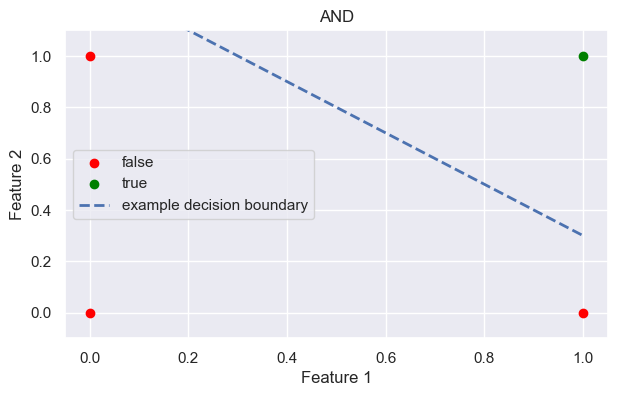

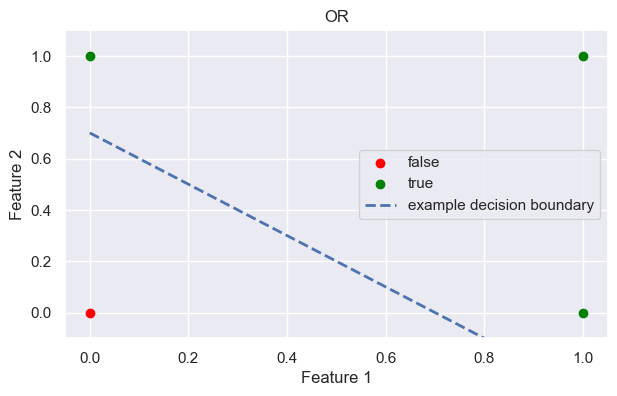

In [9]:
x_ = np.linspace(0,1,2)
def ex_boundary_helper(intercept:float, x:np.ndarray) -> np.ndarray:
    return -x_ + intercept

def visualize_data(X: np.ndarray, y:np.ndarray, title:str, intercept:int, x=x_):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.scatter(X[y==0,0], X[y==0,1], color="red", label="false")
    ax.scatter(X[y==1,0], X[y==1,1], color="green", label="true")
    y = ex_boundary_helper(intercept,x)
    ax.plot(x,y, ls="--", lw=2, label="example decision boundary")
    ax.legend()
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_ylim(-0.1,1.1)
    ax.set_title(title)
    return fig, ax


fig1,ax1 = visualize_data(X, y_and, "AND", 1.3)
fig2,ax2 = visualize_data(X, y_or, "OR",0.7)

## Das Perzeptron als Modell

Das Perzeptron verarbeitet Eingaben in drei aufeinanderfolgenden Schritten:

### 1. Eingabe
Das Modell erhält einen Eingabevektor **x**, den Featurevektor.

### 2. Berechnung
Die Eingabe wird über die Gewichte **w** und den Bias-Parameter **b** linear transformiert.
**z** nennen wir die gewichtete Summe:

$$z = \mathbf{w}^\top \mathbf{x} + b$$

### 3. Ausgabe
Die gewichtete Summe **z** übergeben wir einer nichtlinearen Aktivierungsfunktion, beim Rosenblatt Perceptron klassisch die Step Function. Beim Perzeptron nennen wir das Ergebnis davon die Prediction des Modells:

$$\hat{y} = \text{step}(z) = \begin{cases} 1 & \text{falls } z \geq 0 \\ 0 & \text{sonst} \end{cases}$$

### Vollständiger Datenfluss
Der gesamte Prozess lässt sich wie folgt darstellen:

$$\mathbf{x} \longrightarrow \mathbf{w}^\top \mathbf{x} + b \longrightarrow \text{step}(z) \longrightarrow \hat{y}$$

---

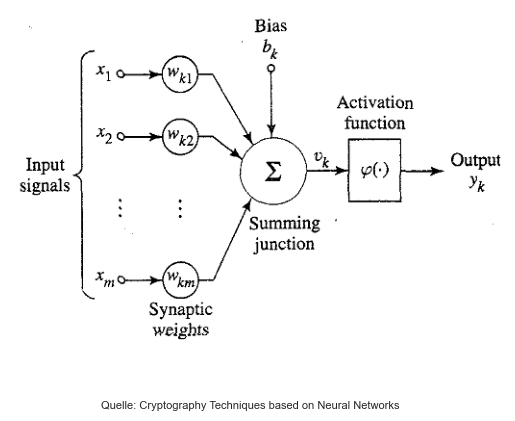

## Aktivierungsfunktion definieren

Neben der eben definierten Step Function, führen wir an dieser Stelle die **Sigmoid** Aktivierungsfunktion ebenfalls ein, welchen wir mit einer modifizierten Lernregel später für das Perzeptron und den Multi Layer Perzeptron verwenden. Im deep learning gibt es eine Vielzahl von verschiedenen Aktivierungen, einige werden wir uns im Verlauf anschauen.

Eine visuelle Inspektion verrät uns auf Anhieb schon einige Eigenschaften, welche direkt sichbar sind, zusätzlich gibt es *versteckte* Eigenschaften, welche man nicht durch das scharfe sehen direkt erkennt. Für uns ist das im Moment irrelevant, da wir erstmal eine Intuition zum Workflow bilden wollen. Wir werden das im Kapitel **Aktivierung** und **Featureraum** der *Beginnersektion* näher beleuchten und später umfassend in der *Intermidatesektion*. 

Sigmoid:
$$ f(x)=\frac{1}{1+e^{-x}} $$

Man erkennt auf Anhieb:
- Wertebereich liegt in **(0,1)**
- monoton steigend
- für große **|x|** nähert sich der Wert **0** oder **1** an
- stetig differenzierbar

Der Ausgabe der Sigmoid-Funktion kann eine Semantik mitgegeben werden. Für die Binärklassifikation bedeutet das:
- $\sigma(z) < 0.5$ → Klasse **0**
- $\sigma(z) >= 0.5$ → Klasse **1**


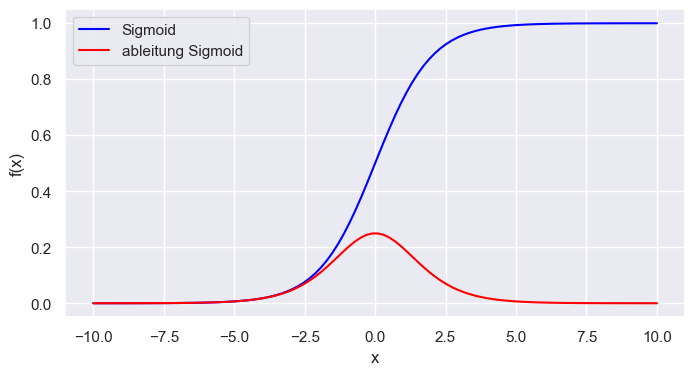

In [4]:
def step_function(x):
  return np.where(x > 0, 1, 0)

def sigmoid(x):
  """Sigmoid-Aktivierungsfunktion"""
  return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
  ds = (np.exp(-x))/(1+np.exp(-x))**2
  return ds

def ReLU(x):
  return np.maximum(0,x)

# Veranschaulichung der Aktivierungsfunktionen
x = np.linspace(-10, 10, 100)
plt.figure(figsize=(8, 4))
# TODO: Plote die Aktivierungsfunktionen

plt.plot(x, sigmoid(x), c="blue", label="Sigmoid")
plt.plot(x,d_sigmoid(x), c="red", label="ableitung Sigmoid")

plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

### 1.3 Perzeptron-Klasse implementieren

Jetzt implementieren wir die Perzeptron-Klasse von Grund auf.

In [ ]:
class Perzeptron:
    def __init__(self, input_size, activation_function):
        """
        Initialisiert ein Perzeptron mit zufälligen Gewichten und Bias.


        Args:
            input_size: Anzahl der Eingabefeatures
        """
        self.rng = np.random.default_rng(seed=53)
        self.w = self.rng.normal(size=input_size)
        self.b = self.rng.uniform()
        self.activation = activation_function

        # TODO: Zufällige Initialisierung von Gewichten und Bias
    def bce(self,y,y_hat):
      bce = -1 * np.mean(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))
      return bce

    def d_bce(self,y,y_hat):
      dL_dyhat = - (y / y_hat) + ((1 - y) / (1 - y_hat))
      return dL_dyhat


    def forward(self, X):
        """
        Berechnet die Ausgabe des Perzeptrons für eine Eingabe X.

        Args:
            X: Eingabedaten, Shape (n_samples, n_features)

        Returns:
            Ausgabe des Perzeptrons, Shape (n_samples, 1)
        """
        # TODO: Implementiere den Forward-Pass
        z = X @ self.w + self.b
        a = self.activation(z)
        return a

    def train_fehlerzaehler(self, X, y , lr=0.1, epochs=1000):
      loss_history = []

      for epoch in range(epochs):
        fehler_count = 0
        for xi, yi in zip(X,y):
            # TODO: Berechnung der Ausgabe
            y_hat = self.forward(xi)

            # TODO: Berechnung des Verlusts
            loss = 0
            delta = float(yi - y_hat)

            # TODO: Update der Gewichte und des Bias
            if delta != 0:
              self.w += lr * delta * xi
              self.b += lr * delta
              fehler_count += 1

        loss = fehler_count/len(y)
        loss_history.append(loss)
        # Alle 100 Epochen Status ausgeben
        if epoch % 100 == 0:
            print(f'Epoche {epoch}: Verlust = {loss:.4f}')


        if fehler_count == 0:
          print(f"Lösung in Epoche {epoch}")
          return loss_history


    def train(self, X, y, learning_rate=0.1, epochs=1000):
        """
        Trainiert das Perzeptron mit Hilfe des Gradientenabstiegs.

        Args:
            X: Eingabedaten, Shape (n_samples, n_features)
            y: Zieldaten, Shape (n_samples, 1)
            learning_rate: Lernrate
            epochs: Anzahl der Trainingsepochen

        Returns:
            Liste mit Verlustwerten für jede Epoche
        """
        loss_history = []

        for epoch in range(epochs):
          e_loss = 0.
          for xi, yi in zip(X,y):
              # TODO: Berechnung der Ausgabe
              y_hat = self.forward(xi)
              z = xi @ self.w + self.b

              # TODO: Berechnung des Verlusts
              loss = self.bce(yi,y_hat)
              e_loss += loss

              # TODO: Update der Gewichte und des Bias
              dL = self.d_bce(yi,y_hat)
              dz = d_sigmoid(z)
              error = dL * dz
              self.w -= learning_rate * error * xi
              self.b -= learning_rate * error

          mean_loss = e_loss / len(y)
          loss_history.append(mean_loss)

          # Alle 100 Epochen Status ausgeben
          if epoch % 100 == 0:
              print(f'Epoche {epoch}: Verlust = {mean_loss:.4f}')

        return loss_history

### 1.4 Perzeptron trainieren

In [ ]:
# Erstelle eine Funktion zur Visualisierung des Trainingsprozesses
def visualize_training(loss_history):
    plt.figure(figsize=(7, 4))
    plt.plot(loss_history, label="Fehlerrate", color="blue")
    plt.xlabel("Epoche")
    plt.ylabel("Fehlerrate")
    plt.title("Trainingsverlauf")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

Epoche 0: Verlust = 0.8155
Epoche 100: Verlust = 0.2755
Epoche 200: Verlust = 0.1740
Epoche 300: Verlust = 0.1274
Epoche 400: Verlust = 0.1002
Epoche 500: Verlust = 0.0824
Epoche 600: Verlust = 0.0698
Epoche 700: Verlust = 0.0605
Epoche 800: Verlust = 0.0534
Epoche 900: Verlust = 0.0477


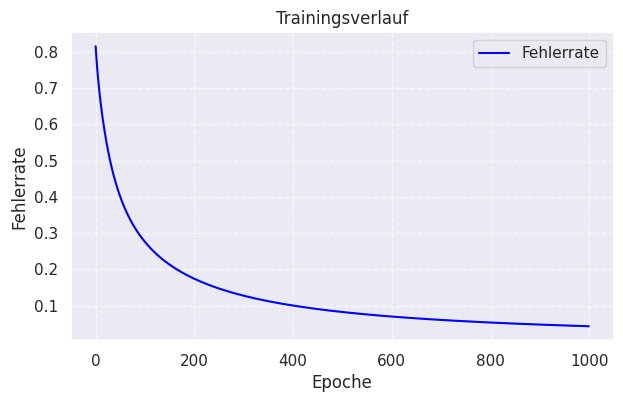

In [ ]:
# Erstelle und trainiere ein Perzeptron
# Was is die input_size?
input_size = X.shape[1]

model = Perzeptron(input_size, sigmoid)
#loss_history = model.train_fehlerzaehler(X, y, lr=0.1, epochs=1000)
loss_history = model.train(X, y, epochs=1000)
# Verlauf des Verlustes visualisieren
visualize_training(loss_history)

### 1.5 Ergebnisse auswerten

In [ ]:
# Vorhersagen mit dem trainierten Perzeptron
predictions = model.forward(X)
print("Eingaben und Vorhersagen:")
for i in range(len(X)):
    print(f"Eingabe: {X[i]}, Erwartete Ausgabe: {y[i]:.1f}, Vorhersage: {predictions[i]:.4f}")

Eingaben und Vorhersagen:
Eingabe: [0. 0.], Erwartete Ausgabe: 0.0, Vorhersage: 0.0002
Eingabe: [0. 1.], Erwartete Ausgabe: 0.0, Vorhersage: 0.0491
Eingabe: [1. 0.], Erwartete Ausgabe: 0.0, Vorhersage: 0.0494
Eingabe: [1. 1.], Erwartete Ausgabe: 1.0, Vorhersage: 0.9323


### 1.6 Entscheidungsgrenze visualisieren

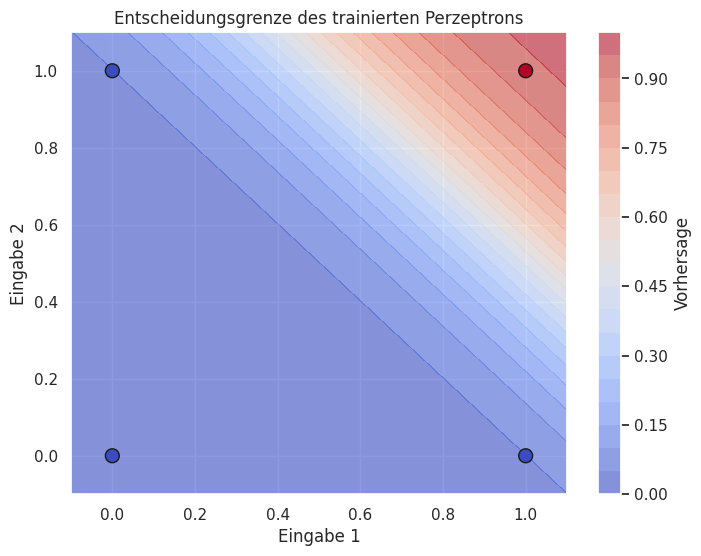

In [ ]:
# Erstelle ein Raster von Punkten
x1 = np.linspace(-0.1, 1.1, 100)
x2 = np.linspace(-0.1, 1.1, 100)
x1_grid, x2_grid = np.meshgrid(x1, x2)
x_grid = np.c_[x1_grid.flatten(), x2_grid.flatten()]

# Vorhersagen für das Raster
y_grid = model.forward(x_grid).reshape(100, 100)

# Visualisierung der Entscheidungsgrenze
plt.figure(figsize=(8, 6))
contour = plt.contourf(x1_grid, x2_grid, y_grid, levels=20, cmap='coolwarm', alpha=0.6)
plt.colorbar(contour, label='Vorhersage')
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), s=100, edgecolors='k', cmap='coolwarm', label='Trainingsdaten')
plt.grid(True)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel('Eingabe 1')
plt.ylabel('Eingabe 2')
plt.title('Entscheidungsgrenze des trainierten Perzeptrons')
plt.show()

## Teil 2: Perzeptron mit PyTorch implementieren

Nachdem wir ein Perzeptron von Grund auf implementiert haben, verwenden wir nun PyTorch - eine moderne Deep-Learning-Bibliothek, die automatisches Differenzieren unterstützt.

In [ ]:
# PyTorch importieren
import torch
import torch.nn as nn
import torch.optim as optim

### 2.1 Daten in PyTorch-Tensoren konvertieren

In [ ]:
# NumPy-Arrays zu PyTorch-Tensoren konvertieren
# TODO: Konvertiere X und y in PyTorch-Tensoren
X_tensor = torch.as_tensor(X, dtype=torch.float32)
y_tensor = torch.as_tensor(y, dtype=torch.float32).unsqueeze(1)

print("PyTorch-Tensor für X:")
print(X_tensor)
print("\nPyTorch-Tensor für y:")
print(y_tensor)

PyTorch-Tensor für X:
tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])

PyTorch-Tensor für y:
tensor([[0.],
        [0.],
        [0.],
        [1.]])


### 2.2 Perzeptron-Modell in PyTorch definieren

In [ ]:
class PyTorchPerzeptron(nn.Module):
    def __init__(self, input_size, activation=nn.Sigmoid):
        """
        Initialisiert ein Perzeptron mit PyTorch.

        Args:
            input_size: Anzahl der Eingabefeatures
        """
        super(PyTorchPerzeptron, self).__init__()
        # Doku zu nn https://pytorch.org/docs/stable/nn.html

        # TODO: Definieren der Architektur mit input_size Eingaben und 1 Ausgabe
        # Hint: Es handelt sich hier um eine einfache lineare Schicht wx+b
        super().__init__()
        self.fc_out = nn.Linear(input_size,1)
        self.activation = activation()

        # TODO: Definiere die Aktivierungsfunktion (zunächst Sigmoid)

    def forward(self, x):
        """
        Forward-Pass durch das Perzeptron.

        Args:
            x: Eingabetensor

        Returns:
            Ausgabe des Perzeptrons
        """
        z_out = self.fc_out(x)
        probs = self.activation(z_out)
        return probs

# Modell initialisieren
# input_size = ?
model_pytorch = PyTorchPerzeptron(input_size)

# Modellstruktur ausgeben
print("Modellarchitektur:")
print(model_pytorch)

Modellarchitektur:
PyTorchPerzeptron(
  (fc_out): Linear(in_features=2, out_features=1, bias=True)
  (activation): Sigmoid()
)


### 2.3 Modell mit PyTorch trainieren

Epoche 0: Verlust = 0.8317
Epoche 100: Verlust = 0.5131
Epoche 200: Verlust = 0.3920
Epoche 300: Verlust = 0.3205
Epoche 400: Verlust = 0.2728
Epoche 500: Verlust = 0.2382
Epoche 600: Verlust = 0.2118
Epoche 700: Verlust = 0.1909
Epoche 800: Verlust = 0.1737
Epoche 900: Verlust = 0.1594


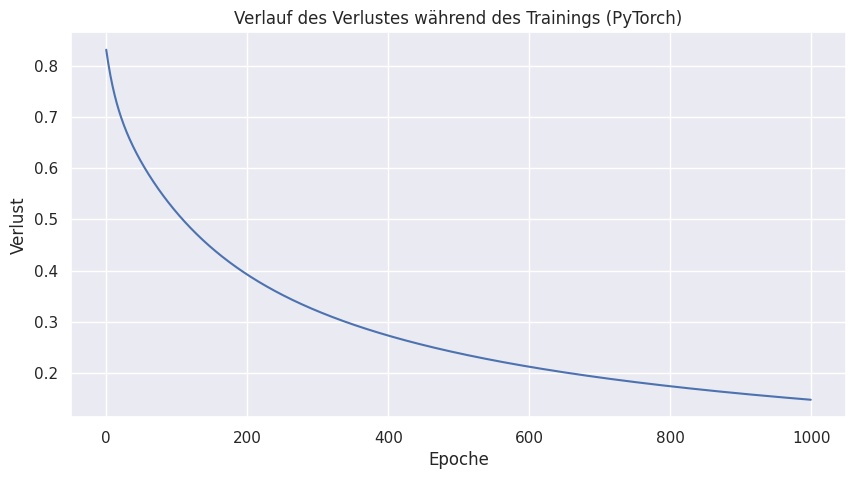

In [ ]:
# Verlustfunktion definieren (Binary Cross Entropy für binäre Klassifikation)
loss_function = nn.BCELoss()

# Optimizer definieren (Stochastic Gradient Descent)
optimizer = optim.SGD(model_pytorch.parameters(), lr=0.1)

# Anzahl der Trainingsepochen
epochs = 1000

# Trainingsschleife
pytorch_loss_history = []

for epoch in range(epochs):
    # Forward-Pass: Vorhersage des Modells
    y_pred = model_pytorch(X_tensor)

    # Berechnung des Verlusts
    loss = loss_function(y_pred, y_tensor)
    pytorch_loss_history.append(loss.item())

    # Zurücksetzen der Gradienten
    optimizer.zero_grad()

    # Backward-Pass: Berechnung der Gradienten
    loss.backward()

    # Aktualisierung der Gewichte
    optimizer.step()

    # Alle 100 Epochen Status ausgeben
    if epoch % 100 == 0:
        print(f'Epoche {epoch}: Verlust = {loss.item():.4f}')

# Verlauf des Verlustes visualisieren
plt.figure(figsize=(10, 5))
plt.plot(pytorch_loss_history)
plt.grid(True)
plt.xlabel('Epoche')
plt.ylabel('Verlust')
plt.title('Verlauf des Verlustes während des Trainings (PyTorch)')
plt.show()

### 2.4 Ergebnisse auswerten

In [ ]:
# Vorhersagen mit dem trainierten PyTorch-Modell
with torch.no_grad():
    predictions_pytorch = model_pytorch(X_tensor)
    print("Eingaben und Vorhersagen (PyTorch):")
    for i in range(len(X)):
        print(f"Eingabe: {X[i]}, Erwartete Ausgabe: {y[i]:.1f}, Vorhersage: {predictions_pytorch[i].item():.4f}")

Eingaben und Vorhersagen (PyTorch):
Eingabe: [0. 0.], Erwartete Ausgabe: 0.0, Vorhersage: 0.0091
Eingabe: [0. 1.], Erwartete Ausgabe: 0.0, Vorhersage: 0.1533
Eingabe: [1. 0.], Erwartete Ausgabe: 0.0, Vorhersage: 0.1531
Eingabe: [1. 1.], Erwartete Ausgabe: 1.0, Vorhersage: 0.7810


### 2.5 Entscheidungsgrenze visualisieren

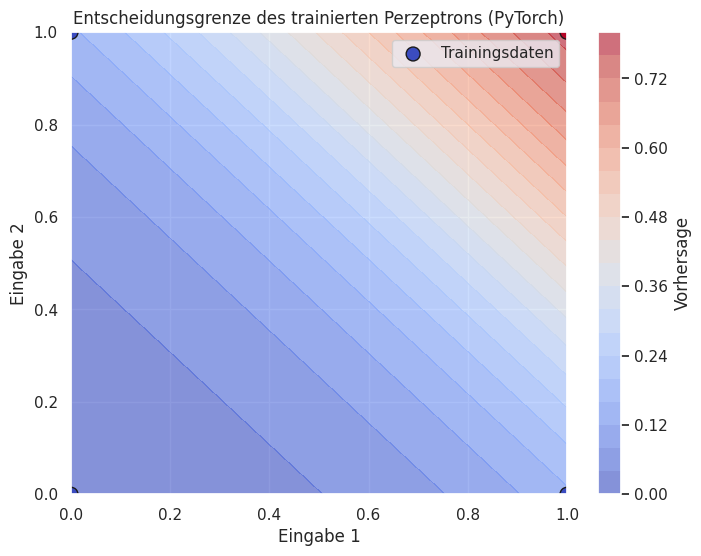

In [ ]:
# Erstelle ein Raster von Punkten
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
x1_grid, x2_grid = np.meshgrid(x1, x2)
x_grid = np.c_[x1_grid.flatten(), x2_grid.flatten()]
x_grid_tensor = torch.FloatTensor(x_grid)

# Vorhersagen für das Raster mit PyTorch
with torch.no_grad():
    y_grid_pytorch = model_pytorch(x_grid_tensor).numpy().reshape(100, 100)

# Visualisierung der Entscheidungsgrenze
plt.figure(figsize=(8, 6))
contour = plt.contourf(x1_grid, x2_grid, y_grid_pytorch, levels=20, cmap='coolwarm', alpha=0.6)
plt.colorbar(contour, label='Vorhersage')
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), s=100, edgecolors='k', cmap='coolwarm', label='Trainingsdaten')
plt.grid(True)
plt.xlabel('Eingabe 1')
plt.ylabel('Eingabe 2')
plt.title('Entscheidungsgrenze des trainierten Perzeptrons (PyTorch)')
plt.legend()
plt.show()

### 2.6 Gewichte des Perzeptrons untersuchen

Gelernte Gewichte (PyTorch): [[2.980207 2.981893]]
Gelernter Bias (PyTorch): [-4.6906557]


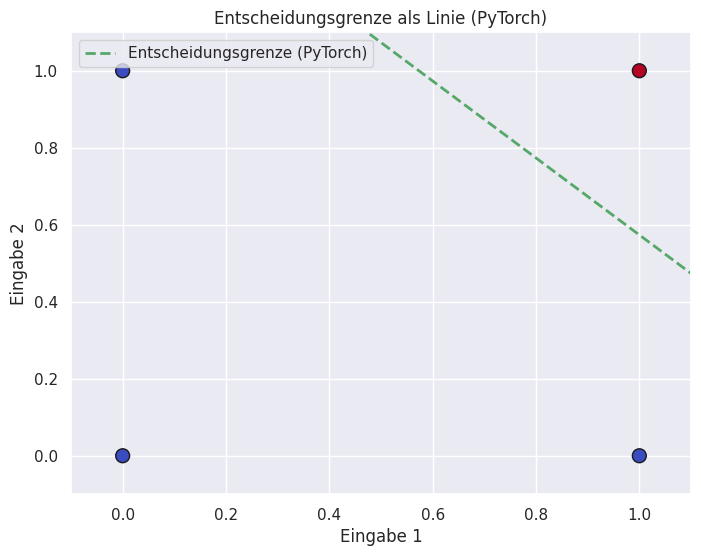

In [ ]:
# Gewichte und Bias des PyTorch-Modells extrahieren
weights_pytorch = model_pytorch.fc_out.weight.data.numpy()
bias_pytorch = model_pytorch.fc_out.bias.data.numpy()

print(f"Gelernte Gewichte (PyTorch): {weights_pytorch}")
print(f"Gelernter Bias (PyTorch): {bias_pytorch}")

# Berechnung der Entscheidungsgrenze in der Form: w1*x1 + w2*x2 + b = 0
# Die Gerade ist gegeben durch: x2 = (-w1*x1 - b) / w2
def decision_boundary_pytorch(x):
    return (-weights_pytorch[0, 0] * x - bias_pytorch[0]) / weights_pytorch[0, 1]

# Visualisierung der Entscheidungsgrgenze als Linie
x_values = np.linspace(-0.1, 1.1, 100)
y_values_pytorch = decision_boundary_pytorch(x_values)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), s=100, edgecolors='k', cmap='coolwarm')
plt.plot(x_values, y_values_pytorch, 'g--', linewidth=2, label='Entscheidungsgrenze (PyTorch)')
plt.grid(True)
plt.xlabel('Eingabe 1')
plt.ylabel('Eingabe 2')
plt.title('Entscheidungsgrenze als Linie (PyTorch)')
plt.legend()
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.show()

## Vergleich der Ergebnisse und Diskussion

Vergleichen Sie die Ergebnisse beider Implementierungen:

1. Sind die gelernten Gewichte und Bias ähnlich?
2. Sind die Entscheidungsgrenzen ähnlich?
3. Welche Vorteile bietet die PyTorch-Implementierung?
4. Was ist der Unterschied im Code zwischen beiden Implementierungen?

### Bonusaufgaben

1. Implementieren Sie das Perzeptron für die XOR-Operation. Warum funktioniert das nicht? Was brauchen wir, um XOR zu lernen?
2. Experimentieren Sie mit verschiedenen Lernraten. Wie wirkt sich das auf das Training aus?
3. Implementieren Sie ein mehrschichtiges neuronales Netz (MLP) mit PyTorch, das die XOR-Operation lernen kann.

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

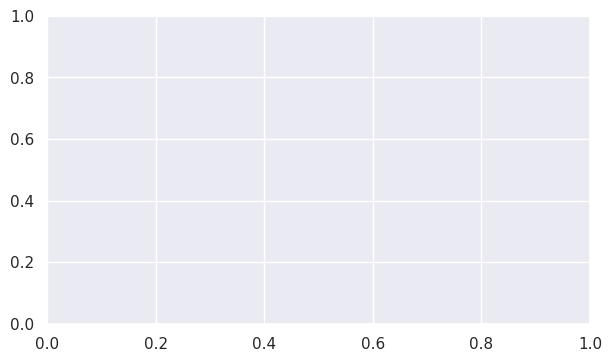

In [ ]:
# Bonusaufgabe 1: XOR-Operation
# Ausgabedaten für XOR-Operation
y_xor = np.array([[0], [1], [1], [0]])

# Visualisieren der XOR-Daten
visualize_data(X, y_xor)
# Versuchen Sie, ein einfaches Perzeptron auf die XOR-Daten zu trainieren
# und beobachten Sie die Ergebnisse!

(4, 2)